In [1]:
%pip install -q \
    pandas \
    numpy \
    matplotlib \
    seaborn \
    plotly \
    scikit-learn \
    scipy \
    tqdm \
    rank-bm25 \
    datasketch \
    tiktoken \
    ipywidgets \
    text-unidecode \
    rich \
    pyarrow

Note: you may need to restart the kernel to use updated packages.


In [1]:
# =========================
# SWE-QA Chunk EDA Notebook
# =========================
# Quick start:
# 1) Укажите пути CHUNKS_DIR и QA_DIR ниже.
# 2) Запустите ячейки по порядку.
# 3) Смотрите блок "Dashboard / Визуализация" и "Паспорт репозитория".

import os
import re
import gc
import json
import math
import glob
import hashlib
import warnings
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import kaleido
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm
from text_unidecode import unidecode
from rich import print as rprint

/Users/22117838/miniconda3/envs/.venv/lib/python3.13/site-packages/kaleido/_sync_server.py:11: UserWarning: 


This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.

  from .kaleido import Kaleido


In [2]:
# Optional deps
try:
    import tiktoken
    _HAS_TIKTOKEN = True
except Exception:
    _HAS_TIKTOKEN = False

try:
    from rank_bm25 import BM25Okapi
    _HAS_BM25 = True
except Exception:
    _HAS_BM25 = False

try:
    from datasketch import MinHash, MinHashLSH
    _HAS_DATASKETCH = True
except Exception:
    _HAS_DATASKETCH = False

In [3]:
# -------------------------
# Config
# -------------------------
CHUNKS_DIR = Path("./data_ragcore/chunks")      # Путь к папке с файлами чанков по репозиториям
QA_DIR     = Path("./data_ragcore/questions")      # Путь к папке с JSONL SWE-QA (по желанию)
OUTPUT_DIR = Path("./eda_output")     # Куда сохранять артефакты

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Лимиты/настройки
SEED = 42
np.random.seed(SEED)

# Для токенов: используйте tiktoken если доступен, иначе эвристика chars/3.5
TOKENIZER_MODEL = "cl100k_base"

# Для MinHash/LSH (почти дубли)
ENABLE_NEAR_DUP = True
NEAR_DUP_JACCARD = 0.9
NEAR_DUP_SHINGLE_N = 5
NEAR_DUP_MAX_DOCS = 150_000  # безопасность по памяти/времени

# Для proxy‑retrieval
ENABLE_RETRIEVAL_PROXY = True
BM25_TOPK = 10
JACCARD_TOPK = 10
MIN_KEYWORD_LEN = 3

In [22]:
# -------------------------
# Utils
# -------------------------
def read_json_or_jsonl(path: Path):
    """
    Читает либо JSON (массив объектов), либо JSONL (по строкам).
    Возвращает список словарей.
    """
    with path.open("r", encoding="utf-8") as f:
        first = f.read(1)
        f.seek(0)
        if first == "[":
            data = json.load(f)
            if isinstance(data, dict):
                data = [data]
            return data
        else:
            rows = []
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    rows.append(json.loads(line))
                except Exception:
                    # иногда в JSONL может встретиться мусор — пропускаем
                    continue
            return rows

def infer_repo_name(path: Path):
    # repo = имя файла без расширения
    return path.stem

def ext_from_name(name: str):
    return ("." + name.split(".")[-1].lower()) if "." in name else ""

def safe_get(d, *keys, default=None):
    cur = d
    for k in keys:
        if cur is None:
            return default
        if isinstance(cur, dict):
            cur = cur.get(k, default)
        else:
            return default
    return cur

def approx_token_count(text: str):
    if not text:
        return 0
    if _HAS_TIKTOKEN:
        try:
            enc = tiktoken.get_encoding(TOKENIZER_MODEL)
        except Exception:
            enc = tiktoken.get_encoding("cl100k_base")
        return len(enc.encode(text))
    # fallback
    return int(len(text) / 3.5)

def normalize_ws(s: str):
    # Убираем невидимые/нелатинские вариации, нормализуем пробелы
    if s is None:
        return ""
    s = unidecode(s)
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"[ \t]+", " ", s)
    return s.strip()

def content_hash(s: str):
    s_norm = normalize_ws(s)
    return hashlib.sha1(s_norm.encode("utf-8")).hexdigest()

def guess_language_from_ext(ext: str):
    mapping = {
        ".py": "python", ".rs": "rust", ".go": "go", ".js": "javascript",
        ".ts": "typescript", ".java": "java", ".cpp": "cpp", ".c": "c",
        ".h": "c", ".hpp": "cpp", ".md": "markdown", ".rst": "rst",
        ".yml": "yaml", ".yaml": "yaml", ".toml": "toml", ".ini": "ini",
        ".cfg": "ini", ".json": "json", ".sh": "bash"
    }
    return mapping.get(ext.lower(), None)

# -------------------------
# File type heuristic
# -------------------------
TEST_DIR_HINTS = ("test", "tests", "testing")
DOC_DIR_HINTS  = ("docs", "doc", "documentation")
SCRIPT_DIR_HINTS = ("scripts", "tools", "bin", "examples", "example", "demo")
CONFIG_EXTS = {".yml", ".yaml", ".toml", ".ini", ".cfg", ".json", ".lock"}
DOC_EXTS = {".md", ".rst", ".ipynb"}
NOTEBOOK_EXTS = {".ipynb"}

def classify_file_type(filepath: str, file_name: str, ext: str):
    fp = (filepath or file_name or "").lower()
    # тесты
    if any(f"/{h}/" in f"/{fp}/" for h in TEST_DIR_HINTS) or re.search(r"(?:^|/)(test_.*|.*_test)\.py$", fp):
        return "test"
    # доки/ноутбуки
    if any(f"/{h}/" in f"/{fp}/" for h in DOC_DIR_HINTS) or ext in DOC_EXTS or ext in NOTEBOOK_EXTS:
        return "docs"
    # конфиги
    if ext in CONFIG_EXTS or any(x in fp for x in ("/.github/", "/.gitlab/", "/.circleci/", "pyproject.toml", "setup.cfg", "setup.py")):
        return "config"
    # скрипты/утилиты/примеры
    if any(f"/{h}/" in f"/{fp}/" for h in SCRIPT_DIR_HINTS) or ext == ".sh":
        return "scripts"
    # всё остальное считаем исходниками
    return "src"

# -------------------------
# Code feature extractors (Python-oriented + generic fallbacks)
# -------------------------
PY_DEF_RE = re.compile(r"(^|\n)\s*def\s+[A-Za-z_][A-Za-z0-9_]*\s*\(", re.M)
PY_CLASS_RE = re.compile(r"(^|\n)\s*class\s+[A-Za-z_][A-Za-z0-9_]*\s*\(", re.M)
PY_IMPORT_RE = re.compile(r"(^|\n)\s*(?:from\s+[A-Za-z0-9_\.]+\s+import|import\s+[A-Za-z0-9_\.]+)", re.M)
GEN_CALL_RE = re.compile(r"\b[A-Za-z_][A-Za-z0-9_]*\s*\(")
PY_DOCSTRING_TRIPLE = re.compile(r'("""|\'\'\')')

def line_stats_and_comments(text: str, language_hint: str = "python"):
    if not text:
        return 0, 0, 0, 0.0, 0.0, 0.0
    lines = text.split("\n")
    n_lines = len(lines)
    non_empty = [ln for ln in lines if ln.strip()]
    n_non_empty = len(non_empty)

    # Комментарии/докстринги (приближение)
    if language_hint == "python":
        n_comment = sum(1 for ln in lines if ln.strip().startswith("#"))
        # грубо считаем строки внутри тройных кавычек как докстринги
        in_doc = False
        doc_lines = 0
        for ln in lines:
            if PY_DOCSTRING_TRIPLE.search(ln):
                # переключатель
                count = len(PY_DOCSTRING_TRIPLE.findall(ln))
                # нечётное количество кавычек — флип флага
                if count % 2 == 1:
                    in_doc = not in_doc
                # если чётное и > 0, может быть открытие и закрытие в одной строке — учитываем тоже
                doc_lines += 1
            elif in_doc:
                doc_lines += 1
        comment_ratio = (n_comment / n_lines) if n_lines else 0.0
        doc_ratio = (doc_lines / n_lines) if n_lines else 0.0
    else:
        # универсальные эвристики
        n_comment = sum(1 for ln in lines if ln.strip().startswith(("//", "#")))
        comment_ratio = (n_comment / n_lines) if n_lines else 0.0
        doc_ratio = 0.0

    avg_line_len = (len(text) / max(1, n_lines))
    return n_lines, n_non_empty, n_comment, comment_ratio, doc_ratio, avg_line_len

def py_symbols_counts(text: str):
    if not text:
        return 0, 0, 0, 0
    def_count = len(PY_DEF_RE.findall(text))
    class_count = len(PY_CLASS_RE.findall(text))
    import_count = len(PY_IMPORT_RE.findall(text))
    call_count = max(0, len(GEN_CALL_RE.findall(text)) - def_count)  # грубо вычтем объявления
    return def_count, class_count, import_count, call_count

# -------------------------
# Load all chunk files
# -------------------------
def load_all_chunks(chunks_dir: Path) -> pd.DataFrame:
    paths = sorted(list(chunks_dir.glob("*.json"))) + sorted(list(chunks_dir.glob("*.jsonl")))
    rows = []
    for p in tqdm(paths, desc=f"Loading chunk files from {chunks_dir}"):
        repo = infer_repo_name(p)
        try:
            data = read_json_or_jsonl(p)
        except Exception as e:
            rprint(f"[red]Failed to read {p}: {e}[/red]")
            continue
        for obj in data:
            content = obj.get("content", "") or ""
            md = obj.get("metadata", {}) or {}
            filepath = safe_get(md, "filepath", default=safe_get(md, "file_path", default=""))
            file_name = safe_get(md, "file_name", default=os.path.basename(filepath) if filepath else "")
            ext = ext_from_name(file_name)
            lang = md.get("language") or guess_language_from_ext(ext) or "unknown"

            row = {
                "repo": repo,
                "content": content,
                "chunk_id": md.get("chunk_id"),
                "filepath": filepath,
                "file_name": file_name,
                "ext": ext,
                "language": lang,
                "chunk_size_chars_meta": md.get("chunk_size"),
                "line_count_meta": md.get("line_count"),
                "start_line": md.get("start_line_no"),
                "end_line": md.get("end_line_no"),
                "node_count": md.get("node_count"),
                "retrieval_relevance_score": obj.get("retrieval_relevance_score"),
                "reranker_relevance_score": obj.get("reranker_relevance_score"),
            }
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

In [27]:
df = load_all_chunks(CHUNKS_DIR)
rprint(f"[bold green]Loaded chunks:[/bold green] {len(df):,} rows, {df['repo'].nunique()} repos")

Loading chunk files from data_ragcore/chunks: 100%|██████████| 15/15 [00:02<00:00,  6.41it/s]


Loaded chunks: 80,710 rows, 15 repos

In [28]:
# -------------------------
# Feature enrichment
# -------------------------
def enrich_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # размеры
    df["size_chars"] = df.apply(lambda r: r["chunk_size_chars_meta"] if pd.notna(r["chunk_size_chars_meta"]) else len(r["content"] or ""), axis=1)
    # строки
    derived_lines = df["content"].fillna("").str.count("\n") + 1
    df["line_count"] = np.where(df["line_count_meta"].notna(), df["line_count_meta"].astype(float), derived_lines)
    df["line_count"] = df["line_count"].astype(int)

    # токены
    tqdm.pandas(desc="Tokenizing")
    df["token_count"] = df["content"].fillna("").progress_apply(approx_token_count)

    # файл-тип
    df["file_type"] = df.apply(lambda r: classify_file_type(str(r.get("filepath") or ""), str(r.get("file_name") or ""), str(r.get("ext") or "")), axis=1)

    # языки: если неизвестно — попробуем из расширения
    df["language"] = df.apply(lambda r: r["language"] if r["language"] not in (None, "", "unknown") else (guess_language_from_ext(r["ext"]) or "unknown"), axis=1)

    # стат. по строкам и комментариям
    # stats = df.apply(lambda r: line_stats_and_comments(r["content"] or "", "python" if r["language"]=="python" else "generic"), axis=1) # ,
    stats = df.apply(lambda r: line_stats_and_comments(r["content"], "python" if r["language"]=="python" else "generic"), axis=1, result_type="expand")
    stats.columns = ["n_lines", "n_non_empty", "n_comment_lines", "comment_ratio", "docstring_ratio", "avg_line_len"]
    df = pd.concat([df, stats], axis=1)

    # кодовые счётчики (для Python; иначе — эвристические вызовы)
    py_counts = df.apply(lambda r: py_symbols_counts(r["content"] or "") if r["language"]=="python" else (0,0,0, max(0, len(GEN_CALL_RE.findall(r["content"] or "")))), axis=1, result_type="expand")
    py_counts.columns = ["def_count", "class_count", "import_count", "call_count"]
    df = pd.concat([df, py_counts], axis=1)

    # плотности
    df["nodes_per_line"] = df.apply(lambda r: (r["node_count"] / r["line_count"]) if (pd.notna(r["node_count"]) and r["line_count"]>0) else np.nan, axis=1)
    df["nodes_per_1k_chars"] = df.apply(lambda r: (1000.0 * r["node_count"] / r["size_chars"]) if (pd.notna(r["node_count"]) and r["size_chars"]>0) else np.nan, axis=1)
    df["imports_per_100_lines"] = 100.0 * df["import_count"] / df["line_count"].replace(0, np.nan)
    df["defs_per_100_lines"] = 100.0 * df["def_count"] / df["line_count"].replace(0, np.nan)
    df["calls_per_100_lines"] = 100.0 * df["call_count"] / df["line_count"].replace(0, np.nan)

    # хэши для дубликатов
    df["sha1_norm"] = df["content"].apply(lambda x: content_hash(x) if isinstance(x, str) else content_hash(""))

    # перекрытия/пробелы по файлам (если есть start/end)
    df["overlap_ratio"] = np.nan
    df["gap_ratio"] = np.nan
    def calc_overlap_gap(group):
        g = group.sort_values(["start_line", "end_line"], kind="mergesort").copy()
        prev_end = None
        res_idx = []
        overlaps = []
        gaps = []
        for idx, row in g.iterrows():
            start, end = row.get("start_line"), row.get("end_line")
            if pd.isna(start) or pd.isna(end):
                res_idx.append(idx); overlaps.append(np.nan); gaps.append(np.nan); prev_end = end
                continue
            length = max(1, int(end) - int(start) + 1)
            if prev_end is None:
                overlap = 0.0
                gap = 0.0
            else:
                overlap = max(0, int(prev_end) - int(start) + 1) / float(length)
                gap = max(0, int(start) - int(prev_end) - 1) / float(length)
                overlap = float(min(1.0, max(0.0, overlap)))
                gap = float(max(0.0, gap))
            res_idx.append(idx); overlaps.append(overlap); gaps.append(gap)
            prev_end = end
        return pd.DataFrame({"idx": res_idx, "overlap_ratio": overlaps, "gap_ratio": gaps}).set_index("idx")
    if df["start_line"].notna().any() and df["end_line"].notna().any():
        by_file = df.groupby(["repo", "filepath"], dropna=False)
        parts = []
        for (rp, fp), sub in tqdm(by_file, desc="Computing overlap/gap by file"):
            try:
                parts.append(calc_overlap_gap(sub))
            except Exception:
                continue
        if parts:
            og = pd.concat(parts, axis=0)
            df.loc[og.index, ["overlap_ratio", "gap_ratio"]] = og[["overlap_ratio", "gap_ratio"]]

    return df

df = enrich_features(df)
rprint(f"[bold blue]Enriched features[/bold blue]: columns = {len(df.columns)}")
df.to_parquet(OUTPUT_DIR / "chunks_enriched.parquet", index=False)

Computing overlap/gap by file: 100%|██████████| 13651/13651 [00:30<00:00, 446.97it/s]


Enriched features: columns = 36

In [29]:
# -------------------------
# Deduplication stats
# -------------------------
def dedup_stats(df: pd.DataFrame):
    g = df.groupby("sha1_norm").size().reset_index(name="dup_count")
    exact_dups = g[g["dup_count"] > 1]["dup_count"].sum() - (len(g[g["dup_count"] > 1]))
    exact_dup_ratio = (g[g["dup_count"] > 1]["dup_count"].sum()) / len(df) if len(df) else 0.0
    return {
        "n_unique_hashes": len(g),
        "n_exact_duplicate_chunks": int((g["dup_count"] > 1).sum()),
        "total_dup_entries_including_copies": int(g[g["dup_count"] > 1]["dup_count"].sum()),
        "exact_dup_ratio_over_rows": float(exact_dup_ratio)
    }

dedup_overall = dedup_stats(df)
rprint("[bold yellow]Exact dedup stats (overall):[/bold yellow]", dedup_overall)

Exact dedup stats (overall):
{
    'n_unique_hashes': 78558,
    'n_exact_duplicate_chunks': 699,
    'total_dup_entries_including_copies': 2851,
    'exact_dup_ratio_over_rows': 0.03532399950439846
}

In [30]:
dup_by_repo = df.groupby("repo").apply(lambda d: pd.Series(dedup_stats(d))).reset_index()
dup_by_repo.to_csv(OUTPUT_DIR / "dup_by_repo.csv", index=False)

# Optional near-duplicates via MinHash/LSH
near_dup_pairs = []
if ENABLE_NEAR_DUP and _HAS_DATASKETCH and len(df) <= NEAR_DUP_MAX_DOCS:
    rprint("[cyan]Building MinHash LSH for near-duplicates...[/cyan]")
    # Шинглы по словам
    def shingles(s, n=NEAR_DUP_SHINGLE_N):
        toks = re.findall(r"[A-Za-z_][A-Za-z0-9_\.]+", s or "")
        return [" ".join(toks[i:i+n]) for i in range(0, max(0, len(toks)-n+1))]

    lsh = MinHashLSH(threshold=NEAR_DUP_JACCARD, num_perm=64)
    signatures = []
    for i, txt in tqdm(enumerate(df["content"].fillna("").tolist()), total=len(df)):
        m = MinHash(num_perm=64)
        for sh in shingles(txt):
            m.update(sh.encode("utf-8"))
        signatures.append(m)
        lsh.insert(i, m)

    for i, m in tqdm(list(enumerate(signatures)), total=len(signatures), desc="Query LSH"):
        cand = lsh.query(m)
        for j in cand:
            if j <= i:
                continue
            near_dup_pairs.append((i, j))
    rprint(f"[green]Near-duplicate pairs found:[/green] {len(near_dup_pairs):,}")
else:
    if not _HAS_DATASKETCH:
        rprint("[magenta]datasketch not installed, skipping near-duplicates.[/magenta]")
    elif len(df) > NEAR_DUP_MAX_DOCS:
        rprint(f"[magenta]Rows > {NEAR_DUP_MAX_DOCS}, skipping near-duplicates for safety.[/magenta]")

# -------------------------
# Repository passport (aggregates)
# -------------------------
def repo_passport(df: pd.DataFrame) -> pd.DataFrame:
    aggs = []
    for repo, sub in df.groupby("repo"):
        rec = {
            "repo": repo,
            "n_chunks": len(sub),
            "n_files": sub["filepath"].nunique(dropna=False),
            "median_tokens": float(np.nanmedian(sub["token_count"])),
            "p90_tokens": float(np.nanpercentile(sub["token_count"], 90)),
            "median_lines": float(np.nanmedian(sub["line_count"])),
            "p90_lines": float(np.nanpercentile(sub["line_count"], 90)),
            "mean_nodes_per_1k_chars": float(np.nanmean(sub["nodes_per_1k_chars"])),
            "mean_comment_ratio": float(np.nanmean(sub["comment_ratio"])),
            "mean_docstring_ratio": float(np.nanmean(sub["docstring_ratio"])),
            "mean_overlap_ratio": float(np.nanmean(sub["overlap_ratio"])),
            "mean_gap_ratio": float(np.nanmean(sub["gap_ratio"])),
            "dup_ratio_exact": float(dedup_stats(sub)["exact_dup_ratio_over_rows"]),
        }
        # типы файлов (проценты)
        ft = (sub["file_type"].value_counts(normalize=True) * 100.0).to_dict()
        for k, v in ft.items():
            rec[f"file_type_{k}_pct"] = float(v)
        # языки (проценты)
        lg = (sub["language"].value_counts(normalize=True) * 100.0).to_dict()
        for k, v in lg.items():
            rec[f"lang_{k}_pct"] = float(v)
        aggs.append(rec)
    out = pd.DataFrame(aggs).fillna(0.0).sort_values("n_chunks", ascending=False)
    return out

passport = repo_passport(df)
passport.to_csv(OUTPUT_DIR / "repo_passport.csv", index=False)
passport.head(10)

/var/folders/cl/dw0grtl92gb4bcfbmtz9jnwdkdqh1z/T/ipykernel_73600/3186063007.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dup_by_repo = df.groupby("repo").apply(lambda d: pd.Series(dedup_stats(d))).reset_index()


Building MinHash LSH for near-duplicates...

Query LSH: 100%|██████████| 80710/80710 [00:04<00:00, 16724.31it/s]


Near-duplicate pairs found: 4,964,876

,repo,n_chunks,n_files,median_tokens,p90_tokens,median_lines,p90_lines,mean_nodes_per_1k_chars,mean_comment_ratio,mean_docstring_ratio,...,mean_gap_ratio,dup_ratio_exact,file_type_test_pct,file_type_src_pct,file_type_scripts_pct,file_type_docs_pct,file_type_config_pct,lang_python_pct,lang_java-script_pct,lang_cpp_pct
13,sympy,19694,1584,143.0,793.0,12.0,71.0,265.927623,0.029699,0.128488,...,0.300437,0.030923,64.623743,34.959886,0.187874,0.213263,0.015233,100.000000,0.000000,0.000000
2,django,10330,2955,71.0,860.0,9.0,100.0,142.228793,0.027843,0.064731,...,0.318823,0.076089,64.259439,35.430784,0.116167,0.193611,0.000000,95.740561,4.259439,0.000000
9,scikit-learn,8417,993,179.0,777.0,18.0,94.4,183.576538,0.074369,0.126620,...,0.417518,0.012237,67.815136,27.135559,4.443388,0.605917,0.000000,98.883213,0.071284,1.045503
0,astropy,8118,964,150.0,761.0,15.0,81.0,185.488522,0.050622,0.164037,...,0.362658,0.012811,65.188470,34.318798,0.357231,0.123183,0.012318,100.000000,0.000000,0.000000
5,pylint,6185,2310,36.0,160.0,5.0,19.0,144.893696,0.022531,0.126141,...,0.473899,0.098302,70.590137,12.239289,0.097009,17.041229,0.032336,100.000000,0.000000,0.000000
4,matplotlib,5867,964,163.0,875.8,16.0,100.0,210.409659,0.063805,0.105794,...,0.516465,0.006818,49.326743,36.577467,12.527697,0.749957,0.818135,92.261803,0.255667,7.482529
10,sphinx,4354,892,138.0,721.1,15.0,100.0,163.056248,0.026878,0.063976,...,0.381873,0.047542,52.526412,46.600827,0.000000,0.872761,0.000000,87.023427,12.976573,0.000000
1,conan,3677,1076,245.0,933.4,23.0,91.0,132.920462,0.033404,0.234958,...,0.168676,0.045689,72.994289,18.330160,8.593962,0.000000,0.081588,100.000000,0.000000,0.000000
14,xarray,3105,233,139.0,651.0,14.0,72.0,208.985257,0.036741,0.081959,...,0.485402,0.005797,54.041868,45.603865,0.000000,0.322061,0.032206,100.000000,0.000000,0.000000
11,sqlfluff,2986,392,125.0,466.5,18.0,69.0,108.219982,0.040265,0.198987,...,0.378276,0.018754,20.730074,78.868051,0.200938,0.200938,0.000000,100.000000,0.000000,0.000000


In [4]:
# -------------------------
# Visualization helpers
# -------------------------
pd.options.display.max_columns = 200
sns.set_theme(style="whitegrid")

def plot_hist_kde(df, column, by="repo", bins=60, log_x=False, title=None):
    plt.figure(figsize=(9,5))
    sns.histplot(data=df, x=column, hue=by, element="step", bins=bins, stat="density", common_norm=False)
    if title:
        plt.title(title)
    if log_x:
        plt.xscale("log")
    plt.tight_layout()
    plt.show()

def plot_violin(df, column, by="repo", title=None, log_y=False):
    plt.figure(figsize=(10,5))
    sns.violinplot(data=df, x=by, y=column, inner="quartile", scale="width")
    plt.xticks(rotation=45, ha="right")
    if log_y:
        plt.yscale("log")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

def corr_heatmap(df, cols, title="Correlation heatmap"):
    plt.figure(figsize=(8,6))
    corr = df[cols].corr(numeric_only=True)
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt='.1g')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_stacked_filetypes(df):
    comp = (df.groupby(["repo","file_type"]).size().reset_index(name="count"))
    total = comp.groupby("repo")["count"].transform("sum")
    comp["pct"] = 100.0 * comp["count"] / total
    fig = px.bar(comp, x="repo", y="pct", color="file_type", title="File types composition by repo (%)", barmode="stack")
    fig.update_layout(xaxis_tickangle=-45, height=500)
    fig.show()

def plot_lang_dist(df):
    comp = (df.groupby(["repo","language"]).size().reset_index(name="count"))
    total = comp.groupby("repo")["count"].transform("sum")
    comp["pct"] = 100.0 * comp["count"] / total
    fig = px.bar(comp, x="repo", y="pct", color="language", title="Language composition by repo (%)", barmode="stack")
    fig.update_layout(xaxis_tickangle=-45, height=500)
    fig.show()

def cdf_plot(series, title, xlabel):
    s = pd.Series(series).dropna().sort_values()
    y = np.linspace(0, 1, len(s), endpoint=False)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=s, y=y, mode="lines", name="CDF"))
    fig.update_layout(title=title, xaxis_title=xlabel, yaxis_title="CDF", height=400)
    fig.show()

In [5]:
df = pd.read_parquet(OUTPUT_DIR / "chunks_enriched.parquet")

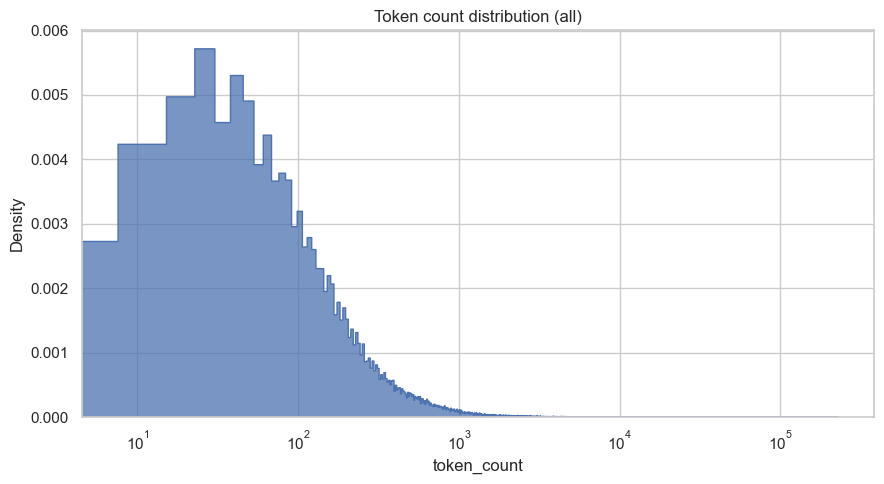

/var/folders/cl/dw0grtl92gb4bcfbmtz9jnwdkdqh1z/T/ipykernel_30747/2090005928.py:19: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x=by, y=column, inner="quartile", scale="width")


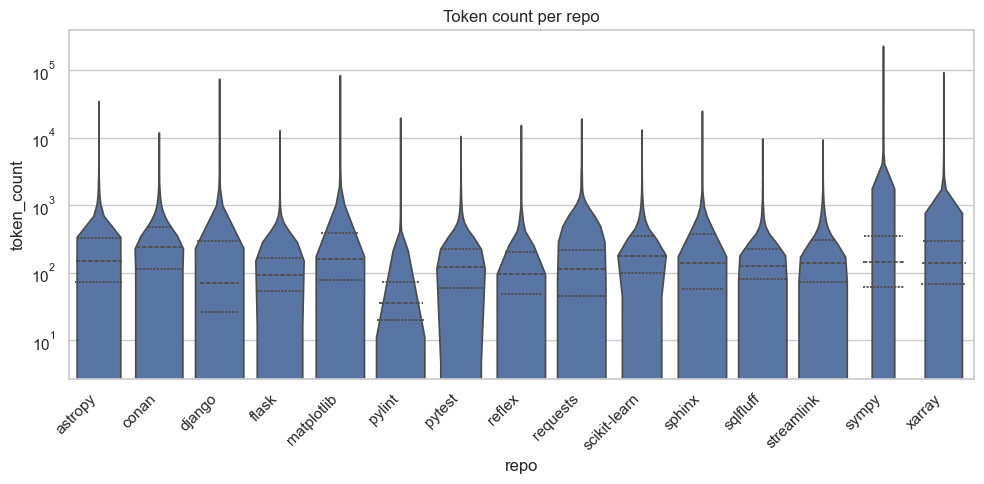

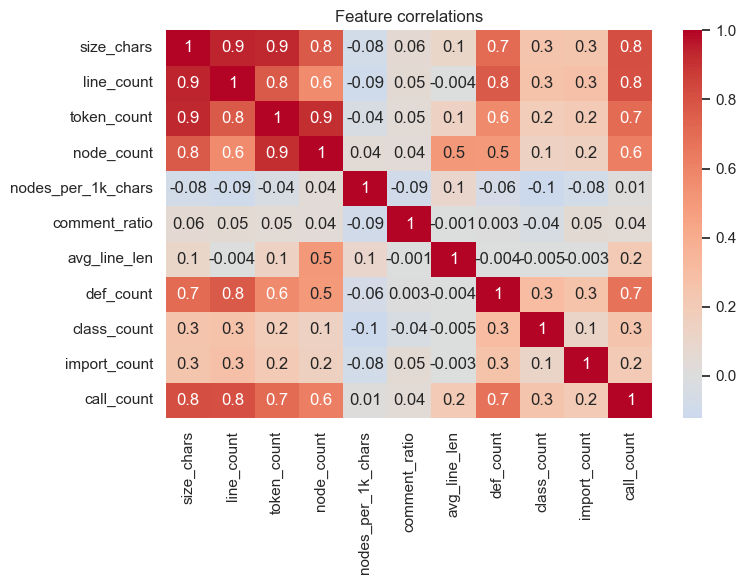

In [6]:
# -------------------------
# Quick overview plots
# -------------------------
# 1) Гистограмма токенов (общая)
plot_hist_kde(df, "token_count", by=None, bins=30000, log_x=True, title="Token count distribution (all)")

# 2) Скрипичные по репозиториям
plot_violin(df, "token_count", by="repo", title="Token count per repo", log_y=True)

# 3) Состав по типам файлов
plot_stacked_filetypes(df)

# 4) Состав по языкам
plot_lang_dist(df)

# 5) Корреляции
corr_cols = ["size_chars","line_count","token_count","node_count","nodes_per_1k_chars","comment_ratio","avg_line_len","def_count","class_count","import_count","call_count"]
corr_heatmap(df, [c for c in corr_cols if c in df.columns], title="Feature correlations")

# 6) CDF по токенам
cdf_plot(df["token_count"], title="CDF of token_count", xlabel="tokens")

In [15]:
# -------------------------
# Top directories (treemap) for a selected repo
# -------------------------
# SELECT_REPO = df["repo"].iloc[3] if len(df) else None
# SELECT_REPO = "flask"

for SELECT_REPO in df.repo.value_counts().keys():
    # if SELECT_REPO is not None:
    sub = df[df["repo"]==SELECT_REPO].copy()
    sub["dir"] = sub["filepath"].fillna("").apply(lambda p: "/".join(p.split("/")[:2]) if "/" in p else (p or "(root)"))
    agg = sub.groupby("dir")["token_count"].sum().reset_index().sort_values("token_count", ascending=False)
    fig = px.treemap(agg, path=["dir"], values="token_count", title=f"Treemap of directories (by tokens) — {SELECT_REPO}")
    fig.update_layout(height=500)
    fig.show()
    # fig.write_image(f"./eda_output/treemaps/{SELECT_REPO}_treemap_of_directories_by_tokens.png")

/var/folders/cl/dw0grtl92gb4bcfbmtz9jnwdkdqh1z/T/ipykernel_30747/2090005928.py:19: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.



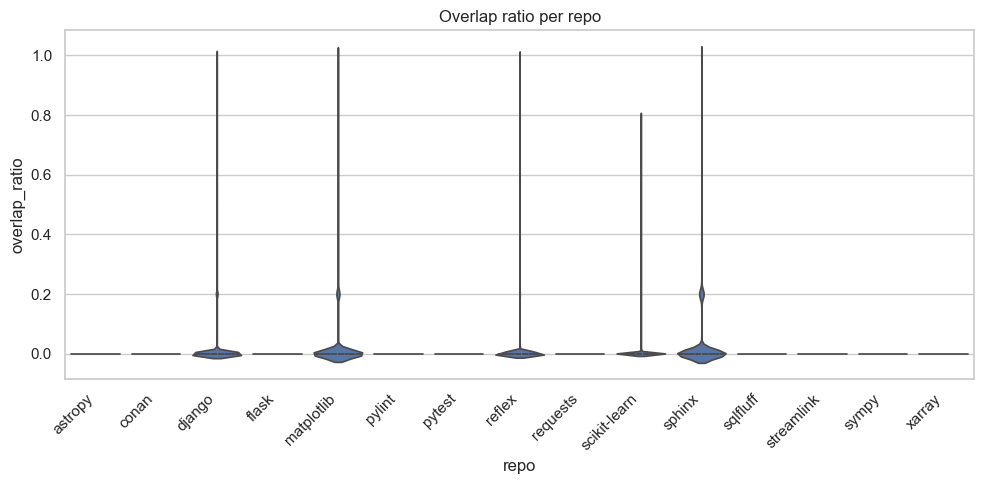

/var/folders/cl/dw0grtl92gb4bcfbmtz9jnwdkdqh1z/T/ipykernel_30747/2090005928.py:19: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.



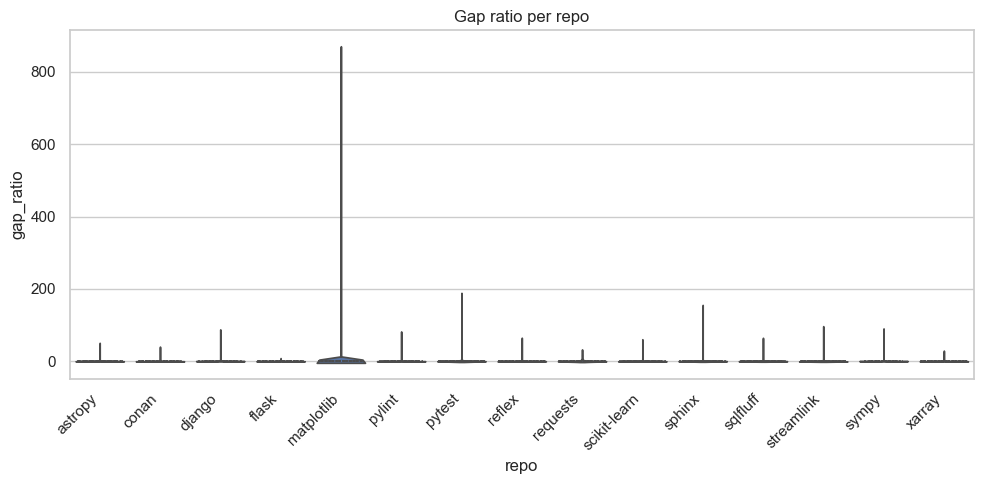

In [16]:
# -------------------------
# Overlap / gap distributions
# -------------------------
if df["overlap_ratio"].notna().any():
    plot_violin(df[df["overlap_ratio"].notna()], "overlap_ratio", by="repo", title="Overlap ratio per repo", log_y=False)
if df["gap_ratio"].notna().any():
    plot_violin(df[df["gap_ratio"].notna()], "gap_ratio", by="repo", title="Gap ratio per repo", log_y=False)

In [18]:
dup_by_repo = pd.read_csv(OUTPUT_DIR / "dup_by_repo.csv")

In [19]:
# -------------------------
# Duplicate ratios
# -------------------------
dup_plot = dup_by_repo.sort_values("exact_dup_ratio_over_rows", ascending=False)
fig = px.bar(dup_plot, x="repo", y="exact_dup_ratio_over_rows", title="Exact duplicate ratio by repo", text=dup_plot["exact_dup_ratio_over_rows"].map(lambda x: f"{100*x:.1f}%"))
fig.update_traces(textposition="outside")
fig.update_layout(xaxis_tickangle=-45, height=450)
fig.show()

In [20]:
# -------------------------
# Keyword frequency / identifiers (per repo)
# -------------------------
def top_identifiers(df, repo, topn=20):
    sub = df[df["repo"]==repo]
    # Простая лексема: модули/идентификаторы
    toks = []
    for t in sub["content"].fillna(""):
        toks.extend(re.findall(r"[A-Za-z_][A-Za-z0-9_\.]{2,}", t))
    cnt = Counter(toks)
    top = pd.DataFrame(cnt.most_common(topn), columns=["token","count"])
    fig = px.bar(top, x="token", y="count", title=f"Top identifiers — {repo}")
    fig.update_layout(xaxis_tickangle=-45, height=450)
    fig.show()
    return top

if SELECT_REPO is not None:
    _ = top_identifiers(df, SELECT_REPO, topn=25)

# -------------------------
# Optional: SWE-QA Retrieval proxy (BM25 + keyword_recall@k)
# -------------------------
def load_swe_qa(qa_dir: Path):
    qa_files = sorted(qa_dir.glob("*.jsonl"))
    rows = []
    for p in qa_files:
        repo = p.stem  # имя файла = репозиторий
        for obj in read_json_or_jsonl(p):
            q = obj.get("question", "")
            a = obj.get("answer", "")
            rows.append({"repo": repo, "question": q, "answer": a})
    return pd.DataFrame(rows)

def normalize_text_for_retrieval(s: str):
    s = s or ""
    s = s.replace("/", " ").replace("_"," ").replace("-", " ").replace(".", " ")
    s = re.sub(r"[^A-Za-z0-9\s#]", " ", s)  # оставим буквы/цифры и '#'
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s

def tokenize_for_retrieval(s: str, min_len=3):
    s = normalize_text_for_retrieval(s)
    toks = [t for t in s.split() if len(t) >= min_len]
    return toks

In [23]:
retrieval_summary = None
if ENABLE_RETRIEVAL_PROXY and _HAS_BM25 and QA_DIR.exists():
    qa_df = load_swe_qa(QA_DIR)
    rprint(f"[blue]Loaded SWE-QA[/blue]: {len(qa_df):,} Q/A from {qa_df['repo'].nunique()} repos")

    rows = []
    for repo, q_sub in qa_df.groupby("repo"):
        # сопоставим название репо из чанков и QA:
        # часто они совпадают (django.jsonl -> repo='django'); иначе понадобится мэппинг
        if repo not in set(df["repo"].unique()):
            # попытка гибкого сопоставления: нижний регистр, без дефисов
            cand = [r for r in df["repo"].unique() if r.replace("-", "").lower()==repo.replace("-", "").lower()]
            if cand:
                repo_key = cand[0]
            else:
                rprint(f"[yellow]Skip QA for repo={repo} (no chunks found)[/yellow]")
                continue
        else:
            repo_key = repo

        chunks_sub = df[df["repo"]==repo_key].copy()
        # используем только содержимое src/docs/test — на ваш выбор
        # здесь берём все типы
        corpus_texts = chunks_sub["content"].fillna("").tolist()
        tokenized_corpus = [tokenize_for_retrieval(t, MIN_KEYWORD_LEN) for t in corpus_texts]
        if not any(tokenized_corpus):
            rprint(f"[yellow]Empty tokenized corpus for {repo_key}[/yellow]")
            continue

        bm25 = BM25Okapi(tokenized_corpus)

        for _, row in q_sub.iterrows():
            q = row["question"] or ""
            q_tokens = tokenize_for_retrieval(q, MIN_KEYWORD_LEN)
            if not q_tokens:
                continue
            scores = bm25.get_scores(q_tokens)
            top_idx = np.argsort(scores)[::-1][:BM25_TOPK]
            top_chunks = [corpus_texts[i] for i in top_idx]
            top_tokens = [set(tokenize_for_retrieval(t, MIN_KEYWORD_LEN)) for t in top_chunks]
            q_set = set(q_tokens)

            # keyword_recall: попал ли хоть один q‑токен в топ‑k чанков
            hit_any = any(len(q_set & ts) > 0 for ts in top_tokens)

            # max Jaccard между вопросом и топ‑k чанками
            max_jacc = 0.0
            for ts in top_tokens:
                u = len(q_set | ts); i = len(q_set & ts)
                if u > 0:
                    max_jacc = max(max_jacc, i / u)

            rows.append({
                "repo": repo_key,
                "question": q,
                "keyword_recall_at_k": 1.0 if hit_any else 0.0,
                "max_jaccard_topk": max_jacc,
                "bm25_top_score": float(scores[top_idx[0]]) if len(top_idx)>0 else 0.0
            })
    retrieval_summary = pd.DataFrame(rows)
    if len(retrieval_summary):
        agg = retrieval_summary.groupby("repo").agg(
            keyword_recall_at_k=("keyword_recall_at_k", "mean"),
            max_jaccard_topk=("max_jaccard_topk", "median"),
            n_questions=("question", "count")
        ).reset_index().sort_values("keyword_recall_at_k", ascending=False)
        rprint("[bold]Retrieval proxy summary (per repo)[/bold]")
        display(agg)

        fig = px.bar(agg, x="repo", y="keyword_recall_at_k", title=f"Keyword recall@{BM25_TOPK} by repo", text=agg["keyword_recall_at_k"].map(lambda x: f"{100*x:.1f}%"))
        fig.update_layout(xaxis_tickangle=-45, height=450)
        fig.update_traces(textposition="outside")
        fig.show()

        fig2 = px.box(retrieval_summary, x="repo", y="max_jaccard_topk", title=f"Max Jaccard(q, top-{BM25_TOPK} chunks) by repo")
        fig2.update_layout(xaxis_tickangle=-45, height=450)
        fig2.show()

Loaded SWE-QA: 720 Q/A from 15 repos

Retrieval proxy summary (per repo)

,repo,keyword_recall_at_k,max_jaccard_topk,n_questions
0,astropy,1.0,0.104715,48
1,conan,1.0,0.113270,48
2,django,1.0,0.108747,48
3,flask,1.0,0.100000,48
4,matplotlib,1.0,0.099296,48
5,pylint,1.0,0.113248,48
6,pytest,1.0,0.104356,48
7,reflex,1.0,0.150758,48
8,requests,1.0,0.080000,48
9,scikit-learn,1.0,0.111111,48


In [ ]:
passport = pd.read_csv(OUTPUT_DIR / "repo_passport.csv")

In [ ]:
# -------------------------
# «Паспорт репозитория» — табличная сводка + спарклайны
# -------------------------
def passport_table(passport_df: pd.DataFrame, df_full: pd.DataFrame, out_csv=OUTPUT_DIR / "repo_passport.csv"):
    # добавим спарклайны p50/p90 токенов как текст
    def spark(vals):
        # мини-спарклайн из квантилей
        p50 = np.nanpercentile(vals, 50) if len(vals)>0 else np.nan
        p90 = np.nanpercentile(vals, 90) if len(vals)>0 else np.nan
        return f"p50={int(p50)}, p90={int(p90)}"
    rows = []
    for _, r in passport_df.iterrows():
        sub = df_full[df_full["repo"]==r["repo"]]["token_count"].dropna().values
        rows.append({
            "repo": r["repo"],
            "n_chunks": int(r["n_chunks"]),
            "n_files": int(r["n_files"]),
            "tokens(p50/p90)": spark(sub),
            "mean_overlap": round(r["mean_overlap_ratio"], 3),
            "mean_gap": round(r["mean_gap_ratio"], 3),
            "comments_mean": round(r["mean_comment_ratio"], 3),
            "dup_exact_ratio": f"{100*r['dup_ratio_exact']:.1f}%",
            "filetype_src%": round(r.get("file_type_src_pct", 0.0), 1),
            "filetype_test%": round(r.get("file_type_test_pct", 0.0), 1),
            "filetype_docs%": round(r.get("file_type_docs_pct", 0.0), 1),
            "filetype_config%": round(r.get("file_type_config_pct", 0.0), 1),
            "filetype_scripts%": round(r.get("file_type_scripts_pct", 0.0), 1),
        })
    out = pd.DataFrame(rows).sort_values("n_chunks", ascending=False)
    out.to_csv(out_csv, index=False)
    display(out.head(20))
    return out

passport_view = passport_table(passport, df)

,repo,n_chunks,n_files,tokens(p50/p90),mean_overlap,mean_gap,comments_mean,dup_exact_ratio,filetype_src%,filetype_test%,filetype_docs%,filetype_config%,filetype_scripts%
0,sympy,19694,1584,"p50=143, p90=793",0.000,0.300,0.030,3.1%,35.0,64.6,0.2,0.0,0.2
1,django,10330,2955,"p50=71, p90=860",0.007,0.319,0.028,7.6%,35.4,64.3,0.2,0.0,0.1
2,scikit-learn,8417,993,"p50=179, p90=777",0.002,0.418,0.074,1.2%,27.1,67.8,0.6,0.0,4.4
3,astropy,8118,964,"p50=150, p90=761",0.000,0.363,0.051,1.3%,34.3,65.2,0.1,0.0,0.4
4,pylint,6185,2310,"p50=36, p90=160",0.000,0.474,0.023,9.8%,12.2,70.6,17.0,0.0,0.1
5,matplotlib,5867,964,"p50=163, p90=875",0.017,0.516,0.064,0.7%,36.6,49.3,0.7,0.8,12.5
6,sphinx,4354,892,"p50=138, p90=721",0.023,0.382,0.027,4.8%,46.6,52.5,0.9,0.0,0.0
7,conan,3677,1076,"p50=245, p90=933",0.000,0.169,0.033,4.6%,18.3,73.0,0.0,0.1,8.6
8,xarray,3105,233,"p50=139, p90=651",0.000,0.485,0.037,0.6%,45.6,54.0,0.3,0.0,0.0
9,sqlfluff,2986,392,"p50=125, p90=466",0.000,0.378,0.040,1.9%,78.9,20.7,0.2,0.0,0.2


In [ ]:
# -------------------------
# Interactive (optional) — ipywidgets
# -------------------------
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    repos = sorted(df["repo"].unique().tolist())
    dd = widgets.Dropdown(options=repos, description="Repo:", value=repos[0] if repos else None)
    out = widgets.Output()

    def render_repo_plots(repo):
        clear_output(wait=False)
        display(dd, out)
        sub = df[df["repo"]==repo]

        fig = px.violin(sub, y="token_count", box=True, points="suspectedoutliers", title=f"Token count — {repo}")
        fig.update_layout(height=400)
        fig.show()

        comp = (sub["file_type"].value_counts(normalize=True)*100.0).reset_index()
        comp.columns = ["file_type","pct"]
        fig2 = px.bar(comp, x="file_type", y="pct", title=f"File types (%) — {repo}")
        fig2.update_layout(height=350)
        fig2.show()

        if sub["overlap_ratio"].notna().any():
            fig3 = px.violin(sub[sub["overlap_ratio"].notna()], y="overlap_ratio", title=f"Overlap ratio — {repo}")
            fig3.update_layout(height=300); fig3.show()

        # Топ-идентификаторы
        _ = top_identifiers(df, repo, topn=20)

    def on_change(change):
        if change["type"] == "change" and change["name"] == "value":
            with out:
                render_repo_plots(change["new"])

    dd.observe(on_change)
    display(dd, out)
    if repos:
        with out:
            render_repo_plots(repos[0])

except Exception as e:
    rprint(f"[magenta]ipywidgets not available: {e}. Skipping interactive dashboard.[/magenta]")

In [ ]:
# -------------------------
# Save lightweight HTML report (static figs)
# -------------------------
try:
    # Пример: сохраним пару ключевых графиков как HTML
    fig = px.histogram(df, x="token_count", nbins=80, title="Token count (all)", log_x=True)
    fig.write_html(OUTPUT_DIR / "hist_token_count_all.html")
    if SELECT_REPO is not None:
        sub = df[df["repo"]==SELECT_REPO].copy()
        fig2 = px.violin(sub, y="token_count", box=True, title=f"Token count — {SELECT_REPO}")
        fig2.write_html(OUTPUT_DIR / f"violin_token_{SELECT_REPO}.html")
    rprint("[green]Saved sample HTML plots to eda_out/[/green]")
except Exception as e:
    rprint(f"[yellow]Failed to save HTML figures: {e}[/yellow]")

# -------------------------
# Next steps suggestions (printed)
# -------------------------
rprint("""
[bold cyan]Готово![/bold cyan]
- Посмотрите repo_passport.csv / dup_by_repo.csv в eda_out/.
- Используйте интерактивный виджет для просмотра репозиториев.
- Включите/выключите ENABLE_NEAR_DUP и ENABLE_RETRIEVAL_PROXY по необходимости.
""")